# EDA on Subject Demographics

Coco Yu  
December 11, 2024

## Code Status

## Notes

## Setup

Chunk Defaults

In [ ]:
knitr::opts_chunk$set(attr.output='style="max-height: 500px;"')


Conflicts

In [ ]:
options(conflicts.policy = "depends.ok")


In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

here() starts at /Users/yujiachen/Desktop/github/study_messages

Source Functions

In [ ]:
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

Absolute Paths

In [ ]:
path_messages <- format_path(str_c("studydata/risk/data_processed/messages"))
path_shared <- format_path(str_c("studydata/risk/data_processed/shared"))


## Prepare Data

Read in Data

In [ ]:
labels <- read_csv(here(path_messages, "lapses.csv"), col_types = cols()) |> 
  mutate(day_start = as_datetime(day_start, tz = "America/Chicago"),
         day_end = as_datetime(day_end, tz = "America/Chicago"))

screen <- read_csv(here::here(path_shared, "screen.csv"),
                   col_types = cols()) |>
  select(c(starts_with("dem"), subid)) |> 
  glimpse()


Rows: 208
Columns: 16
$ dem_1   <dbl> 57, 35, 22, 39, 22, 38, 22, 38, 25, 45, 63, 50, 53, 26, 52, 54…
$ dem_2   <chr> "Male", "Female", "Female", "Male", "Male", "Male", "Female", …
$ dem_3   <chr> "White/Caucasian", "White/Caucasian", "White/Caucasian", "Whit…
$ dem_3_1 <chr> NA, NA, NA, NA, NA, NA, NA, NA, "Filipino and Black", NA, NA, …
$ dem_4   <chr> "No, I am not of Hispanic, Latino, or Spanish origin", "No, I …
$ dem_4_1 <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ dem_5   <chr> "College degree", "2-Year degree", "High school or GED", "Coll…
$ dem_6   <chr> "Unemployed", "Employed", "Employed", "Employed", "Employed", …
$ dem_6_1 <chr> NA, "Full-time", "Full-time", "Full-time", "Part-time", "Full-…
$ dem_7   <dbl> 12000, 36920, 20064, 130000, 5000, 70000, 8000, 57000, 10000, …
$ dem_8   <chr> "Never Married", "Never Married", "Never Married", "Married", …
$ dem2_2  <dbl> 2, 2, 4, 1, 2, 1, 4, 2, 2, 2, 0, 2, 3, 2, 1, 0, 2, 2, 2, 1, 2,…
$ dem2_4  <dbl> 0,

Merge dataframes

In [ ]:
demographics <- labels |> 
  left_join(screen, by = "subid") |> 
  select(-day_start, -day_end, -lapse) |> 
  distinct()


Clean up – rename columns and make binary

In [ ]:
demographics <- demographics |>
  mutate(
    race = case_when(
      dem_3 == "White/Caucasian" & grepl("No", dem_4) ~ "white",
      dem_3 != "White/Caucasian" | grepl("Yes", dem_4) ~ "non_white"),
    sex = if_else(dem_2 == "Female", "female", "male"),
    age = if_else(dem_1 >= 55, "older", "younger"),
    income = if_else(dem_7 <= .5 * 30000, "below_poverty", "above_poverty")
  ) |> 
  select(-starts_with("dem")) |> 
  glimpse()


Rows: 138
Columns: 5
$ subid  <dbl> 2, 3, 5, 6, 7, 10, 11, 15, 16, 18, 19, 20, 21, 23, 25, 26, 27, …
$ race   <chr> "white", "white", "white", "white", "white", "white", "non_whit…
$ sex    <chr> "female", "female", "male", "male", "male", "female", "male", "…
$ age    <chr> "younger", "younger", "younger", "younger", "younger", "younger…
$ income <chr> "above_poverty", "above_poverty", "above_poverty", "below_pover…

In [ ]:
output <- rbind(
  data.frame(table(demographics$sex)),
  data.frame(table(demographics$race)),
  data.frame(table(demographics$income)),
  data.frame(table(demographics$age))
)

output$demographics <- rep(c("sex", "race", "income", "age"), each = 2)
output <- output |> 
  rename(subgroup = Var1, N = Freq) |> 
  relocate(demographics)
output <- output[c(2, 1, 4, 3, 5, 6, 8, 7),]
output |> mutate(percent = N / 138) |> print_kbl()


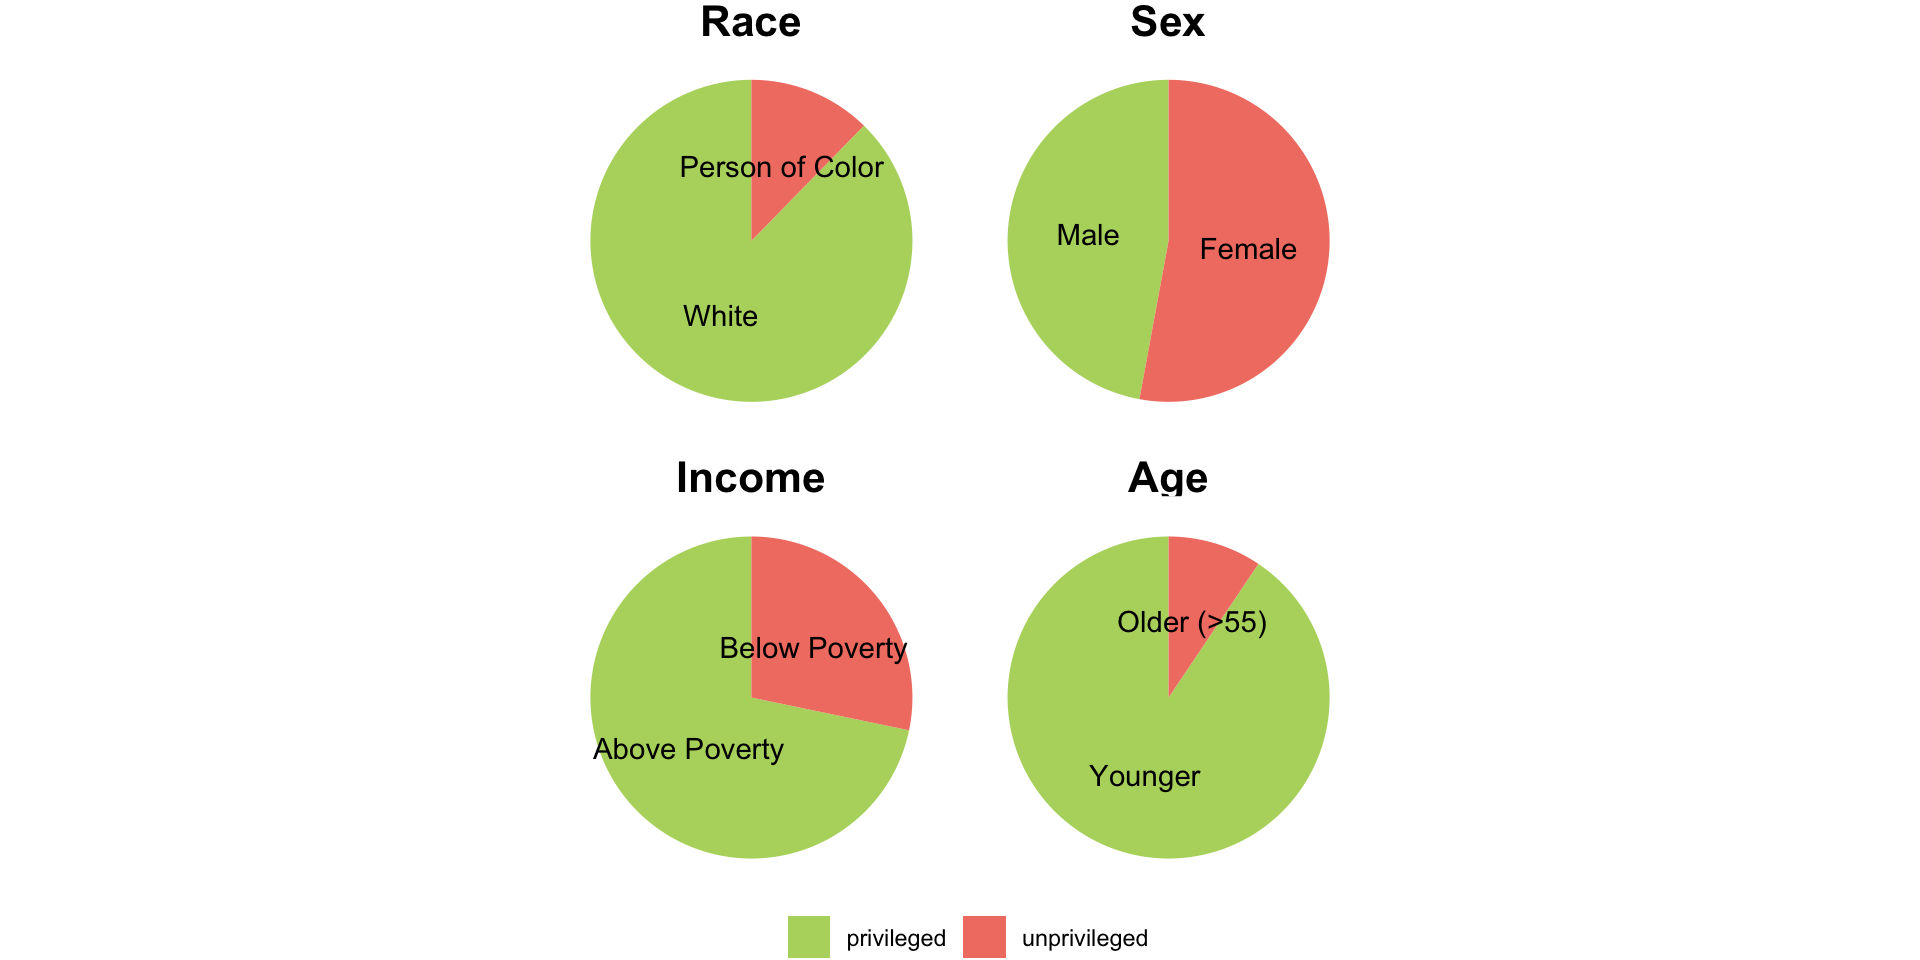

In [ ]:
output |> 
  mutate(
    subgroup = case_when(
      subgroup == "female" ~ "unprivileged",
      subgroup == "male" ~ "privileged",
      subgroup == "white" ~ "privileged",
      subgroup == "non_white" ~ "unprivileged",
      subgroup == "above_poverty" ~ "privileged",
      subgroup == "below_poverty" ~ "unprivileged",
      subgroup == "younger" ~ "privileged",
      subgroup == "older" ~ "unprivileged"
    ),
    demographics = case_when(
      demographics == "sex" ~ "Sex",
      demographics == "race" ~ "Race",
      demographics == "income" ~ "Income",
      demographics == "age" ~ "Age"
    )
  ) |> 
 ggplot(aes(x = "", y = N, fill = subgroup)) + 
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  scale_fill_manual(values = c("privileged" = "#B5D66E",
                               "unprivileged" = "#F28072")) +
  geom_text(aes(label = c(
    "Male",
    "Female",
    "White",
    "Person of Color",
    "Above Poverty",
    "Below Poverty",
    "Younger",
    "Older (>55)"
  )), position = position_stack(vjust = 0.5)) +
  theme_void() +
  theme(legend.title=element_blank(), legend.position = "bottom") +
  facet_wrap(~factor(demographics, levels = c("Race", "Sex", "Income", "Age"))) +
  theme(strip.text.x = element_text(size = 16, face="bold")) 


In [ ]:
data <- labels |> 
  left_join(demographics, by = "subid")


In [ ]:
data |> tabyl(sex, lapse)


    sex lapse no lapse
 female   507     5607
   male   375     5073

      race lapse no lapse
 non_white    99     1346
     white   783     9334

     age lapse no lapse
   older   130     1007
 younger   752     9673

        income lapse no lapse
 above_poverty   607     7737
 below_poverty   275     2943

In [ ]:
data |> 
  group_by(lapse, sex) |> 
  summarize(
    n = n(),
    perc = n() / nrow(data)
  )


`summarise()` has grouped output by 'lapse'. You can override using the
`.groups` argument.

# A tibble: 4 × 4
# Groups:   lapse [2]
  lapse    sex        n   perc
  <chr>    <chr>  <int>  <dbl>
1 lapse    female   507 0.0439
2 lapse    male     375 0.0324
3 no lapse female  5607 0.485 
4 no lapse male    5073 0.439 

`summarise()` has grouped output by 'lapse'. You can override using the
`.groups` argument.

# A tibble: 4 × 4
# Groups:   lapse [2]
  lapse    race          n    perc
  <chr>    <chr>     <int>   <dbl>
1 lapse    non_white    99 0.00856
2 lapse    white       783 0.0677 
3 no lapse non_white  1346 0.116  
4 no lapse white      9334 0.807  

`summarise()` has grouped output by 'lapse'. You can override using the
`.groups` argument.

# A tibble: 4 × 4
# Groups:   lapse [2]
  lapse    age         n   perc
  <chr>    <chr>   <int>  <dbl>
1 lapse    older     130 0.0112
2 lapse    younger   752 0.0650
3 no lapse older    1007 0.0871
4 no lapse younger  9673 0.837 

`summarise()` has grouped output by 'lapse'. You can override using the
`.groups` argument.

# A tibble: 4 × 4
# Groups:   lapse [2]
  lapse    income            n   perc
  <chr>    <chr>         <int>  <dbl>
1 lapse    above_poverty   607 0.0525
2 lapse    below_poverty   275 0.0238
3 no lapse above_poverty  7737 0.669 
4 no lapse below_poverty  2943 0.255 

In [ ]:
data |> 
  group_by(sex) |> 
  summarize(
    lapse = sum(lapse == "lapse") / n()
  )


# A tibble: 2 × 2
  sex     lapse
  <chr>   <dbl>
1 female 0.0829
2 male   0.0688

# A tibble: 2 × 2
  race       lapse
  <chr>      <dbl>
1 non_white 0.0685
2 white     0.0774

# A tibble: 2 × 2
  age      lapse
  <chr>    <dbl>
1 older   0.114 
2 younger 0.0721

# A tibble: 2 × 2
  income         lapse
  <chr>          <dbl>
1 above_poverty 0.0727
2 below_poverty 0.0855